# Initilization

In [ ]:
# coding:utf-8
%matplotlib inline
#import sympy
import scipy
# init_session()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import *
import itertools
from itertools import chain, permutations
import os
import pickle
import random
seed(1234)

In [2]:
import read_data
df = read_data.read_data()


def is_ascii(string):
    """return true if non ascii characters are detected in the given string
    """
    if string:
        return max([ord(char) for char in string]) < 128
    return True


def texts2list(texts):
    stop_words = set('for a of the and to in by with'.split())
    if type(texts) == list:
        texts = pd.Series(texts)
    texts = texts.str.lower().str.translate(str.maketrans('()', '  '))
    texts = texts.str.strip()
    textlist = [[
        word for word in document.translate(
            str.maketrans('\'()[],.&?"{}-_:;', '                ')).split()
        if word not in stop_words
    ] for document in texts]
    return textlist


#Select AE reported in English
df = df[df['AEDECOD'].apply(is_ascii)]
df['AETERM'] = df['AETERM'].str.lower()
#drop duplicate
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

#create coder and decoder
pt = df['AEDECOD'].drop_duplicates()
coder = {}
for i, word in enumerate(pt):
    coder.update({word: i})
    i = i + 1
decoder = dict([(pt, index) for index, pt in coder.items()])
dest = os.path.join('.', 'data', 'coder.pkl')
pickle.dump(coder, open(dest, 'wb'), protocol=4)


def count_aeterm(df):
    texts = texts2list(df['AETERM'])
    check = [len(text) for text in texts]
    df['len'] = check
    print('distribution of number of words per AETERM')
    print('data\n', df['len'].value_counts().sort_index())


count_aeterm(df)

distribution of number of words per AETERM
data
 1      573
2     1869
3     1558
4      893
5      259
6       62
7       20
8        9
9        2
15       1
Name: len, dtype: int64


In [3]:
from keras.models import Model, Sequential
from keras.engine import Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, LSTM, Activation, Dropout
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, CSVLogger
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

wikimodel = Word2Vec.load("./data/wiki.en.word2vec.model")
wvsize = wikimodel.vector_size
MAX_WORDS = 5

texts = texts2list(df['AETERM'])
dictset = list(set(chain.from_iterable(texts)))
wvdict = dict(
    [(dic, wikimodel[dic]) for dic in dictset if dic in wikimodel.wv.vocab])

Using TensorFlow backend.


In [4]:
def texts2wv(texts):
    wv = [
        np.array([wvdict[word] for word in text if word in wvdict.keys()])
        for text in texts
    ]
    nonull = [len(vector) for vector in wv]
    x = [
        np.array([
            wvdict[word] for (i, word) in enumerate(text)
            if word in wvdict.keys()
        ]) for text in texts
    ]
    x_norm = [x[i][0:MAX_WORDS] for i in range(len(x))]
    x_all = np.array([
        np.append(x_norm[i].flat,
                  np.zeros(wvsize * max(MAX_WORDS - len(x_norm[i]), 0)))
        for i in range(len(x_norm))
    ])
    return x_all, nonull


texts = texts2list(df['AETERM'])
x_all, nonnull = texts2wv(texts)
df['nonnull'] = nonnull
df = df[df.nonnull > 0]
df_all = df.copy()

In [ ]:
sizeflag = df_all.groupby("AEDECOD").size().reset_index()
sizeflag.columns = ['AEDECOD', 'AEDECOD_SIZE']
df = pd.merge(df_all, sizeflag, on="AEDECOD", how="left")

df.reset_index(drop=True, inplace=True)

# Select AEDECOD which have 2 or more record
df = df[df['AEDECOD_SIZE'] >= 2]
df.reset_index(drop=True, inplace=True)

print("Unique PT(#>=1): ", len(df_all[~df_all['AEDECOD'].duplicated()]))
print("Unique PT(#>=2): ", len(df[~df['AEDECOD'].duplicated()]))


def sampling(groupdf):
    groupdf['target'] = np.append(
        permutation(2), binomial(n=1, p=0.8, size=len(groupdf) - 2))
    return groupdf


# Data Split
df = df.groupby("AEDECOD").apply(sampling)

print('All Record')
count_aeterm(df_all)
print('#AEDECOD>=2')
count_aeterm(df)

Unique PT(#>=1):  1553
Unique PT(#>=2):  721
All Record
distribution of number of words per AETERM
data
 1      429
2     1858
3     1557
4      893
5      259
6       62
7       20
8        9
9        2
15       1
Name: len, dtype: int64
#AEDECOD>=2
distribution of number of words per AETERM
data
 1      297
2     1503
3     1336
4      815
5      227
6       54
7       15
8        8
9        2
15       1
Name: len, dtype: int64


# Words Shuffling

In [ ]:
df_test = df.query('target==0')
df_train = df.query('target==1')
# Shuffle
texts = texts2list(df_train['AETERM'])
decods = df_train['AEDECOD']

# All shuffled words
# shuffled = []
# shuffled = [ list(perm) + [decod,] for text, decod in zip(texts, decods) for perm in list(permutations(text,r=MAX_WORDS))]

# Random sampling from shuffled words
MAX_SEQ = 5
shuffled = []
for text, decod in zip(texts, decods):
    #Number of permuations
    pr = scipy.special.perm(len(text), min(MAX_WORDS, len(text)), exact=True)
    #Sampling from shuffled words
    perms = random.sample(
        list(permutations(text, r=min(MAX_WORDS, len(text)))), min(pr, MAX_SEQ))
    for perm in perms:
        shuffled.append(list(perm) + [decod,])

In [7]:
y_train = [coder[pt[-1]] for pt in shuffled]
y_train = to_categorical(y_train)
x_train = [record[0:-1] for record in shuffled]
x_train, nonnull = texts2wv(x_train)

y_test = [coder[pt] for pt in df_test['AEDECOD']]
y_test = to_categorical(y_test)
x_test = texts2list(df_test['AETERM'])
x_test, nonnull = texts2wv(x_test)

length of y_train= 1524
x_train_rnn.shape=, y_train.shape= (11124, 5, 400) (11124, 1524)
x_test_rnn.shape= (11124, 5, 400)


/home/yo/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1524, kernel_initializer=<function ...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 200)               400800    
_________________________________________________________________
dense_1 (Dense)              (None, 1524)              306324    
_________________________________________________________________
activation_1 (Activation)    (None, 1524)              0         
Total params: 707,124
Trainable params: 707,124
Non-trainable params: 0
_________________________________________________________________


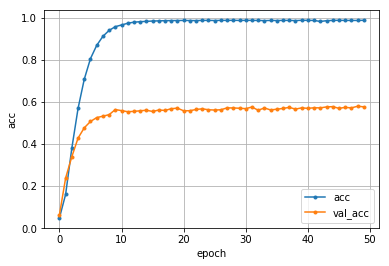

test loss: 2.9668670182
test acc: 0.590694006497


In [8]:
from keras.layers.wrappers import Bidirectional
from keras.layers import SimpleRNN
from keras.optimizers import Adam

n_hidden = 100
n_out = len(y_train[0])

x_train_rnn = x_train.reshape(len(x_train), MAX_WORDS, wvsize)
x_test_rnn = x_test.reshape(len(x_test), MAX_WORDS, wvsize)

print("length of y_train=", n_out)
print("x_train_rnn.shape=, y_train.shape=", x_train_rnn.shape, y_train.shape)
print("x_test_rnn.shape=", x_train_rnn.shape)


def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)


# model = Sequential()
# model.add(Bidirectional(SimpleRNN(n_hidden),
#                         input_shape=(MAX_WORDS, wvsize)))
# model.add(Dense(n_out, init=weight_variable))
# model.add(Activation('softmax'))

model = Sequential()
model.add(Bidirectional(LSTM(n_hidden), input_shape=(MAX_WORDS, wvsize)))
model.add(Dense(n_out, init=weight_variable))
model.add(Activation('softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    metrics=['accuracy'])

# model.compile(loss='categorical_crossentropy',
#               optimizer=SGD(lr=0.1),
#               metrics=['accuracy'])

model.summary()

es = EarlyStopping(monitor='val_loss', patience=2)
csv_logger = CSVLogger('training.log')
epochs = 50
batch_size = 50

hist = model.fit(
    x_train_rnn,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    validation_split=0.2)

# plot results
acc = hist.history['acc']
val_acc = hist.history['val_acc']

epochs = len(acc)
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

score = model.evaluate(x_test_rnn, y_test, verbose=0)
print('test loss:', score[0])
print('test acc:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 400)               800400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 400)               160400    
__________

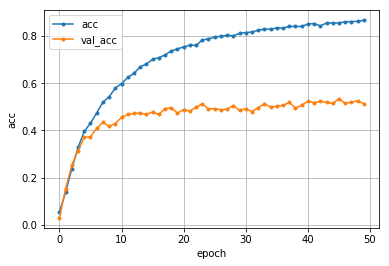

In [9]:
n_in = len(x_train[0])
n_hidden = 400
n_out = len(y_train[0])
dropout_rate = 0.4

model = Sequential()
model.add(Dense(n_hidden, input_dim=n_in))
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))

model.add(Dense(n_hidden))
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))

model.add(Dense(n_hidden))
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))

model.add(Dense(n_hidden))
model.add(Dropout(dropout_rate))
model.add(Activation('relu'))

model.add(Dense(n_out))
model.add(Activation('softmax'))

model.summary()

# model.compile(loss='categorical_crossentropy',
#               optimizer=SGD(lr=1),
#               metrics=['accuracy'])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=2)
csv_logger = CSVLogger('training.log')
epochs = 50
batch_size = 50

hist = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.1)

#,                  callbacks=[es, csv_logger]

# evaluate model
score = model.evaluate(x_test, y_test, verbose=0)
print('test loss:', score[0])
print('test acc:', score[1])

# plot results
acc = hist.history['acc']
val_acc = hist.history['val_acc']

epochs = len(acc)
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [ ]:
# Not shuffle words

texts = texts2list(df['AETERM'])
x_all, nonull = texts2wv(texts)
y_all = np.asarray(
    [coder[df['AEDECOD'][i]] for i in range(0, len(df['AEDECOD']))])
y_all = to_categorical(y_all)
target = df['target']

In [ ]:
from keras.layers.wrappers import Bidirectional
from keras.layers import SimpleRNN
from keras.optimizers import Adam

n_hidden = 200
n_out = len(y_all[0])


def split_data(x, y, target):
    x_train = x[target == 1]
    x_test = x[target == 0]
    y_train = y[target == 1]
    y_test = y[target == 0]
    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = split_data(x_all, y_all, target)

x_train = x_train.reshape(len(x_train), MAX_WORDS, wvsize)
x_test = x_test.reshape(len(x_test), MAX_WORDS, wvsize)

print("length of y_all=", n_out)
print("x_all.shape=, y_all.shape=", x_all.shape, y_all.shape)
print("x_train.shape=", x_train.shape)


def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)


model = Sequential()
model.add(Bidirectional(SimpleRNN(n_hidden), input_shape=(MAX_WORDS, wvsize)))
model.add(Dense(n_out, init=weight_variable))
model.add(Activation('softmax'))

# model = Sequential()
# model.add(Bidirectional(LSTM(n_hidden),
#                         input_shape=(MAX_WORDS, wvsize)))
# model.add(Dense(n_out, init=weight_variable))
# model.add(Activation('softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
#               metrics=['accuracy'])

model.compile(
    loss='categorical_crossentropy', optimizer=SGD(lr=1), metrics=['accuracy'])

model.summary()

es = EarlyStopping(monitor='val_loss', patience=2)
csv_logger = CSVLogger('training.log')
epochs = 100
batch_size = 100

hist = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    validation_split=0.1)

# plot results
acc = hist.history['acc']
val_acc = hist.history['val_acc']

epochs = len(acc)
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

score = model.evaluate(x_test, y_test, verbose=0)
print('test loss:', score[0])
print('test acc:', score[1])

In [ ]:
n_in = len(x_all[0])
n_hidden = 400
n_out = len(y_all[0])
print(n_in, n_out)
print(x_all.shape, y_all.shape)


def split_data(x, y, target):
    x_train = x[target == 1]
    x_test = x[target == 0]
    y_train = y[target == 1]
    y_test = y[target == 0]
    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = split_data(x_all, y_all, target)
#x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

model = Sequential()
model.add(Dense(n_hidden, input_dim=n_in))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(n_hidden))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(n_hidden))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(n_hidden))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(n_hidden))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(n_hidden))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(n_hidden))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(n_out))
model.add(Activation('softmax'))

model.summary()

# model.compile(loss='categorical_crossentropy',
#               optimizer=SGD(lr=1),
#               metrics=['accuracy'])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=2)
csv_logger = CSVLogger('training.log')
epochs = 100
batch_size = 100

hist = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    validation_split=0.1)

#,                  callbacks=[es, csv_logger]

# evaluate model
score = model.evaluate(x_test, y_test, verbose=0)
print('test loss:', score[0])
print('test acc:', score[1])

# plot results
acc = hist.history['acc']
val_acc = hist.history['val_acc']

epochs = len(acc)
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [ ]:
y_predict = model.predict(x_test)

y_test_decode = [decoder[i] for i in np.where(y_test == 1)[1]]
y_predict_decode = [decoder[i] for i in y_predict.argmax(axis=1)]
y_decode = pd.DataFrame(
    np.array([y_test_decode, y_predict_decode]).T, columns=['test', 'predict'])

#print(y_decode[0:10])
dfx = df[df["target"] == 0].reset_index(drop=True, inplace=False)
result = pd.concat([dfx, y_decode], axis=1)
result['judge'] = result['AEDECOD'] == result['predict']
result['check'] = result['AEDECOD'] == result['test']
#result['check'].sum()
accuracy = 100 * result['judge'].sum() / len(result)
print('Accuracy: %.2f' % accuracy)
summary = result.groupby('len').sum()
summary['Acurracy'] = 100 * summary['judge'] / summary['check']
summary

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=None)
#from sklearn.linear_model import LogisticRegression
#model = LogisticRegression(random_state=None)
y_train_cat = np.where(y_train == 1)[1]
y_test_cat = np.where(y_test == 1)[1]
model.fit(x_train, y_train_cat)

from sklearn.metrics import accuracy_score
pred_train = model.predict(x_train)
accuracy_train = accuracy_score(y_train_cat, pred_train)
print('SVM training accuracy: %.2f' % accuracy_train)

pred_test = model.predict(x_test)
accuracy_test = accuracy_score(y_test_cat, pred_test)
print('SVMtest accuracy: %.2f' % accuracy_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

forest = RandomForestClassifier(min_samples_leaf=3, random_state=0)
forest.fit(x_train, y_train)

pred_train = model.predict(x_train)
accuracy_train = accuracy_score(y_train_cat, pred_train)
print('RF training accuracy: %.2f' % accuracy_train)

pred_test = model.predict(x_test)
accuracy_test = accuracy_score(y_test_cat, pred_test)
print('RF test accuracy: %.2f' % accuracy_test)

In [ ]:
y_train_decode = [decoder[i] for i in np.where(y_train == 1)[1]]

In [ ]:
model.save('./data/model.h5')

In [ ]:
intexts = texts2list(["Vomit a food", "low back pain"])
x_in, nonull = texts2wv(intexts)
y_predict = model.predict(x_in)
decoder = dict([(pt, index) for index, pt in coder.items()])

In [ ]:
index = y_predict.argmax(axis=1)

In [ ]:
decoder[index[0]]

In [ ]:
y_predict.argmax(axis=1)

In [ ]:
from keras.preprocessing.text import Tokenizer
import numpy as np
from gensim.models import Word2Vec, KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from itertools import chain
import pandas as pd

wikimodel = Word2Vec.load("./data/wiki.en.word2vec.model100")
#wikimodel = KeyedVectors.load_word2vec_format("./data/test.model",binary=False)
#with open('/home/yo/PycharmProjects/coding/data/test.model','rb') as f:
#    wikimodel = pickle.load(f)

wvsize = wikimodel.vector_size
MAX_WORDS = 5


def is_ascii(string):
    """return true if non ascii characters are detected in the given string
    """
    if string:
        return max([ord(char) for char in string]) < 128
    return True


def texts2list(texts):
    stop_words = set('for a of the and to in by with'.split())
    if type(texts) == list:
        texts = pd.Series(texts)
    texts = texts.str.lower().str.translate(str.maketrans('()', '  '))
    texts = texts.str.strip()
    textlist = [[
        word for word in document.translate(
            str.maketrans('\'()[],.&?"{}-_:;', '                ')).split()
        if word not in stop_words
    ] for document in texts]
    return textlist


def texts2wv(texts):
    dictset = list(set(chain.from_iterable(texts)))
    wvdict = dict([(dic, wikimodel[dic]) for dic in dictset
                   if dic in wikimodel.wv.vocab])
    wvsize = wikimodel.vector_size
    wv = [
        np.array([wvdict[word] for word in text if word in wvdict.keys()])
        for text in texts
    ]
    nonull = [len(vector) for vector in wv]
    x = [
        np.array([
            wvdict[word] for (i, word) in enumerate(text)
            if word in wvdict.keys()
        ]) for text in texts
    ]
    x_norm = [x[i][0:MAX_WORDS] for i in range(len(x))]
    x_all = np.array([
        np.append(x_norm[i].flat,
                  np.zeros(wvsize * max(MAX_WORDS - len(x_norm[i]), 0)))
        for i in range(len(x_norm))
    ])
    return x_all, nonull


from keras.models import load_model
model = load_model('./data/model.h5')

import pickle
import os
with open(os.path.join('.', 'data', 'coder.pkl'), 'rb') as f:
    coder = pickle.load(f)

In [ ]:
y_predict[1]

In [ ]:
print(intexts)
print(x_in)
print(nonnull)
print(y_predict)
print(index)
print(pt)


In [ ]:
wvsize

In [ ]:
try:
    import cPickle as pickle
except:
    import pickle

with open('/home/yo/PycharmProjects/coding/data/wikimodel', 'wb') as f:
    pickle.dump(wikimodel, f)
f.closed

#wikimodel.save('/home/yo/PycharmProjects/coding/data/test.model',sep_limit=100*1024**2)

In [ ]:
try:
    import cPickle as pickle
except:
    import pickle

with open('/home/yo/PycharmProjects/coding/data/test.model', 'rb') as f:
    wikimodel = pickle.load(f)

#wvsize = wikimodel.vector_size

wikimodel.vector_size

In [ ]:
with open('/home/yo/PycharmProjects/coding/data/test.model.bin',
          'rb') as gcs_file:
    test = gcs_file.read()
from gensim.models import Word2Vec, KeyedVectors